In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [6]:
print("Loading training and testing data...")
try:
    train_df = pd.read_csv("training_data.csv")
    test_df = pd.read_csv("testing_data.csv")
    print(f"Successfully loaded training_data.csv (Shape: {train_df.shape})")
    print(f"Successfully loaded testing_data.csv (Shape: {test_df.shape})")
except FileNotFoundError:
    print("Error: training_data.csv or testing_data.csv not found.")
    exit()

Loading training and testing data...
Successfully loaded training_data.csv (Shape: (204592, 17))
Successfully loaded testing_data.csv (Shape: (51149, 17))


In [7]:
target_column = 'prali_fire'

In [8]:
def preprocess_features(df):
    """Applies minimal feature engineering."""
    df = df.copy()
    df['acq_hour'] = df['acq_time'].astype(str).str.zfill(4).str[:2].astype(int)
    return df

print("\nApplying minimal preprocessing...")
train_df_processed = preprocess_features(train_df)
test_df_processed = preprocess_features(test_df)


Applying minimal preprocessing...


In [9]:
new_numeric_features = [
    'brightness', 'scan', 'track', 'confidence', 'bright_t31', 
    'frp', 'type', 'acq_hour'
]

In [10]:
new_categorical_features = [
    'satellite', 'instrument', 'daynight'
]

In [11]:
all_features = new_numeric_features + new_categorical_features
print(f"Training model with {len(all_features)} features.")

Training model with 11 features.


In [12]:
X_train = train_df_processed[all_features]
y_train = train_df_processed[target_column]

In [13]:
X_test = test_df_processed[all_features]
y_test = test_df_processed[target_column]

print("Preprocessing complete.")

Preprocessing complete.


In [14]:
# --- 5. Create Preprocessing Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [15]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, new_numeric_features),
        ('cat', categorical_transformer, new_categorical_features)
    ])

In [17]:
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'  # <--- THIS IS THE MODIFICATION
)

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [19]:
print("\nTraining BALANCED Random Forest model...")
pipeline.fit(X_train, y_train)
print("Model training complete.")


Training BALANCED Random Forest model...
Model training complete.


In [22]:
print("\n--- BALANCED Model Evaluation (No Shortcuts) ---")
y_pred = pipeline.predict(X_test)
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"BALANCED Model Accuracy: {accuracy:.4f} ({(accuracy * 100):.2f}%)")


--- BALANCED Model Evaluation (No Shortcuts) ---
BALANCED Model Accuracy: 0.8254 (82.54%)


In [23]:
# Show a detailed Classification Report
print("\nBALANCED Classification Report:")
report = classification_report(y_test, y_pred)
print(report)


BALANCED Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     39883
           1       0.65      0.44      0.53     11266

    accuracy                           0.83     51149
   macro avg       0.75      0.69      0.71     51149
weighted avg       0.81      0.83      0.81     51149



Generating BALANCED Confusion Matrix plot...
Saved 'confusion_matrix_balanced.png'


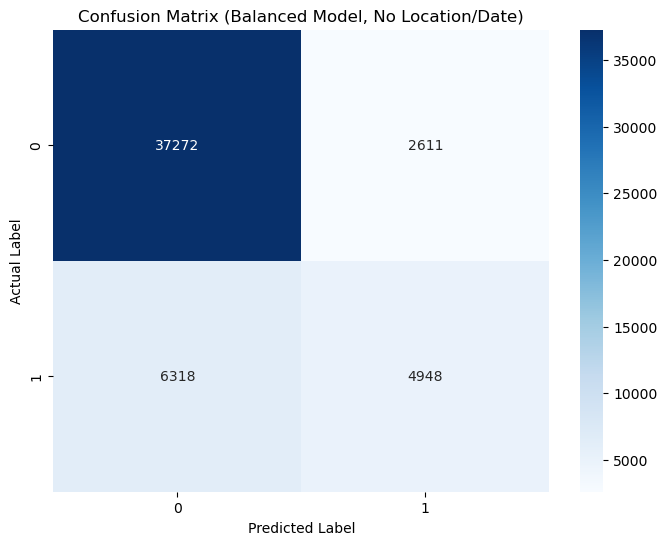

In [24]:
print("Generating BALANCED Confusion Matrix plot...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Balanced Model, No Location/Date)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_balanced.png')
print("Saved 'confusion_matrix_balanced.png'")

Generating BALANCED Feature Importance plot...

Top 10 Most Important Features (Balanced Model):
       feature  importance
0   brightness    0.239535
4   bright_t31    0.231142
5          frp    0.197805
7     acq_hour    0.100467
1         scan    0.069807
2        track    0.065016
6         type    0.038924
10  daynight_D    0.026375
11  daynight_N    0.023320
3   confidence    0.007609


C:\Users\ashu\AppData\Local\Temp\ipykernel_7060\3741363334.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature',


Saved 'feature_importances_balanced.png'

--- All done! ---


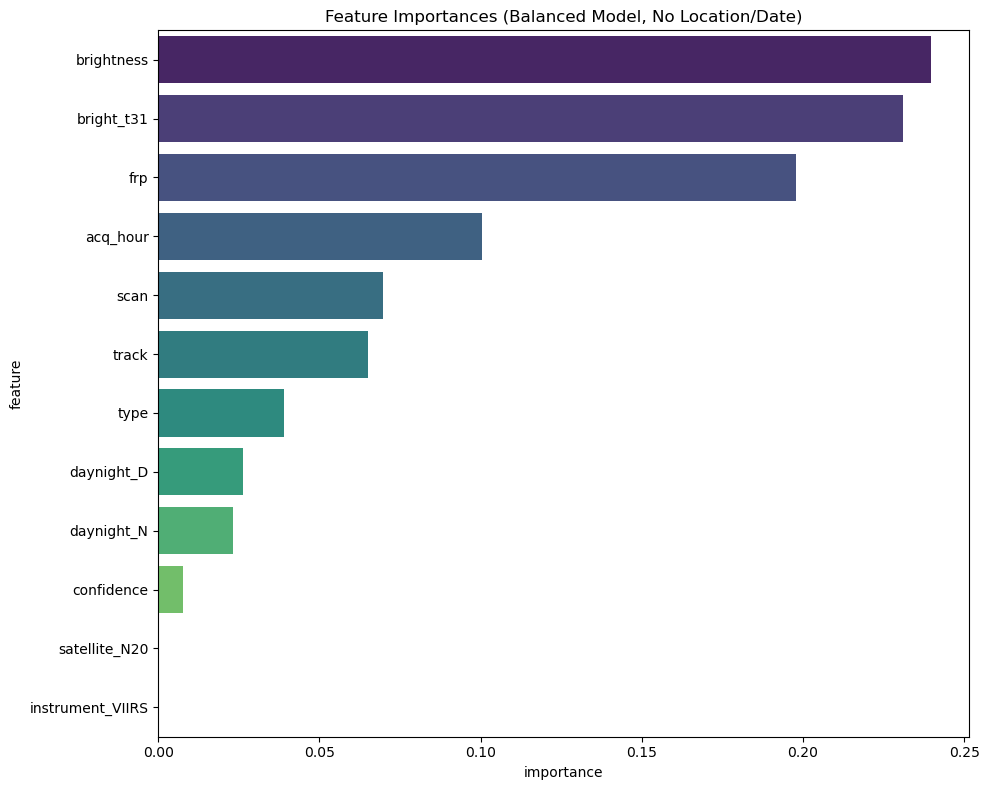

In [25]:
print("Generating BALANCED Feature Importance plot...")
try:
    ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(new_categorical_features)
    all_feature_names = new_numeric_features + list(ohe_feature_names)

    importances = pipeline.named_steps['classifier'].feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    print("\nTop 10 Most Important Features (Balanced Model):")
    print(feature_importance_df.head(10))
    
    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', 
                data=feature_importance_df.head(20), 
                palette='viridis')
    plt.title('Feature Importances (Balanced Model, No Location/Date)')
    plt.tight_layout()
    plt.savefig('feature_importances_balanced.png')
    print("Saved 'feature_importances_balanced.png'")

except Exception as e:
    print(f"Could not plot feature importances: {e}")

print("\n--- All done! ---")

In [26]:
import joblib